<a href="https://colab.research.google.com/github/SEJUNTONY/Data_Science_Class/blob/main/%EB%AC%B4%EC%97%AD%EB%8D%B0%EC%9D%B4%ED%84%B0_%EB%B2%A0%ED%8A%B8%EB%82%A8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [52]:
# 라이브러리 로드
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker

In [53]:
# 함수

def outliers_iqr(data) :
    q1, q3 = np.percentile(data, [25,75])
    iqr = q3 - q1
    lower_bound = 0
    upper_bound = 3000

    return np.where((data > upper_bound)|(data<lower_bound))

def get_outlier(df=None, column=None, weight=1.5):
    # target 값과 상관관계가 높은 열을 우선적으로 진행
    quantile_25 = np.percentile(df[column].values, 25)
    quantile_75 = np.percentile(df[column].values, 75)

    IQR = quantile_75 - quantile_25
    IQR_weight = IQR*weight

    lowest = quantile_25 - IQR_weight
    highest = quantile_75 + IQR_weight

    outlier_idx = df[column][ (df[column] < lowest) | (df[column] > highest) ].index
    return outlier_idx

In [54]:
# 데이터 로드

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [55]:
# 무역 데이터 확인

filename = '/content/drive/MyDrive/데이터사이언스모임/무역데이터_베트남/무역_베트남.csv'
vietnam = pd.read_csv(filename)
vietnam.head(10)

,EXPOR_NTN_NM,HS_CD,ARRVL_YRMNT,VTNM_TRAD_INVCE_AMT,ARRVL_PRT_NM
0,CHINA,85322400,2021-02-22,10.92,VNCLI
1,CHINA,85030090,2021-02-22,224.32,VNCLI
2,CHINA,84733090,2021-02-22,3840.00,VNSGN
3,CHINA,82075000,2021-02-22,62.00,VNCLI
4,CHINA,85076090,2021-02-22,9.15,VNSGN
5,CHINA,84439990,2021-02-22,155073.60,VNDVU
6,CHINA,85423900,2021-02-22,2278.62,VNDVU
7,CHINA,85444299,2021-02-22,16.65,VNHAN
8,CHINA,83082000,2021-02-22,8.70,VNCLI
9,CHINA,84241090,2021-02-22,1290.00,VNDTS


# 1. 기본정보 확인

EXPOR_NTN_NM, HS_CD, ARRVL_YRMNT, ARRVL_PRT,NM은 **범주형 변수**

VTNM_TRAD_INVCE_AMT는 **수치형 변수**로 파악된다.


컬럼정의서에 따르면 각 컬럼의 의미는 다음과 같다.

1. EXPOR_NTM_NM : 수출국가명
2. HS_CD : HS코드
3. ARRVL_YRMNT
4. VTNM_TRAD_INVCE_AMT : 베트남무역송장금액
5. ARRVL_PRT_NM : 도착항구명

무역데이터에 대한 상향식 접근 방식(Bottom Up Approach)을 고민해볼 것이다.

* 상향식 접근 방식(Bottom Up Approach) : 문제의 정의 자체가 어려운 경우, 데이터를 기반으로 문제의 재정의 및 해결방안을 탐색하고, 이를 지속적으로 개선하는 방식

데이터 분석을 진행하고 싶은 사항은 다음과 같다.

1. HSCODE별 평균 가격 중 높은 순서로 분석

2. 항구별 HSCODE 빈도수가 높은 것

3. 전체 항구의 거래량 파악 : ARRVL_YRMNT 빈도수 파악

In [56]:
vietnam.shape

(9999, 5)

5개의 Column이 있다.

In [57]:
vietnam.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9999 entries, 0 to 9998
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   EXPOR_NTN_NM         9999 non-null   object 
 1   HS_CD                9999 non-null   int64  
 2   ARRVL_YRMNT          9999 non-null   object 
 3   VTNM_TRAD_INVCE_AMT  9999 non-null   float64
 4   ARRVL_PRT_NM         9999 non-null   object 
dtypes: float64(1), int64(1), object(3)
memory usage: 390.7+ KB


In [58]:
# VTNM_TRAD_INVCE_AMT에 대한 기술통계 Summary
vietnam['VTNM_TRAD_INVCE_AMT'].describe()

count    9.999000e+03
mean     3.891812e+05
std      5.702677e+06
min      0.000000e+00
25%      9.000000e+01
50%      5.250000e+02
75%      3.040380e+03
max      2.409840e+08
Name: VTNM_TRAD_INVCE_AMT, dtype: float64

기술통계값을 확인해보니, 최소 송장금액이 0인 값이 존재하는 것을 보아, 모델에 오류를 불러일으킬만한 데이터가 존재함을 확인할 수 있다.

In [59]:
# 송장금액이 0인 값을 제거
A = vietnam[vietnam['VTNM_TRAD_INVCE_AMT']==0].index
vietnam = vietnam.drop(A)

In [60]:
# 0값 제거 후 VTNM_TRAD_INVCE_AMT에 대한 기술통계 Summary
vietnam['VTNM_TRAD_INVCE_AMT'].describe()

count    9.987000e+03
mean     3.896488e+05
std      5.706087e+06
min      1.000000e-02
25%      9.000000e+01
50%      5.266100e+02
75%      3.045040e+03
max      2.409840e+08
Name: VTNM_TRAD_INVCE_AMT, dtype: float64

제대로 시행되었음을 확인하였다. 0이 제거된 상태로 히스토그램을 그려보았다.


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


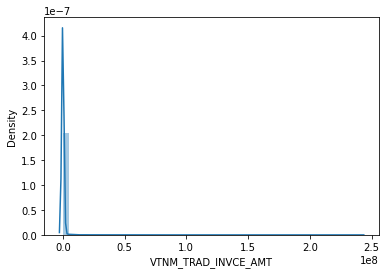

In [61]:
# 히스토그램(histogram)
sns.distplot(vietnam['VTNM_TRAD_INVCE_AMT'])

완전히 치우침을 확인할 수 있다. 대체적으로 몰려있는 쪽에 비해 특정 값들이 매우 높아 이런 히스토그램이 그려지는 듯 하다.

In [62]:
# 왜도 및 첨도
print("Skewness : %f" % vietnam['VTNM_TRAD_INVCE_AMT'].skew())
print("Kurtosis : %f" % vietnam['VTNM_TRAD_INVCE_AMT'].kurt())

Skewness : 25.926753
Kurtosis : 817.102347


왜도 : 자료가 심하게 오른쪽으로 치우쳐있음
첨도 : 심각하게 뾰족한 정규분포의 형태를 보인다.

## 1. HSCODE별 평균 가격 중 높은 순서로 분석

### (1) HS 코드 분석

평균 가격을 파악하기 이전, HS코드를 분석해보았다.

In [63]:
vietnam['HS_CD'].unique()

array([85322400, 85030090, 84733090, ..., 34029099, 29362800, 69149000])

In [64]:
vietnam['HS_CD'].nunique()

2089

HS코드는 총 2089가지가 있는 것으로 파악된다. 이 값들을 모두 분석할 수는 없기에 상위 값들만을 통해 분석을 진행한다.

In [65]:
rname = vietnam['HS_CD']
hscode_total = pd.DataFrame(vietnam['HS_CD'].value_counts(), index=rname, )
hscode_total

,HS_CD
HS_CD,
85322400,79
85030090,26
84733090,30
82075000,21
85076090,17
...,...
84719090,6
39259000,3
87149199,13


상위값을 차지하고 있는 품목은 다음과 같다.
1. 39269099
2. 73269099
3. 85332100

거래되는 상위 3개 품목을 확인해본 결과, 플라스틱 소재 등 산업재가 많았다.

https://news.kotra.or.kr/user/globalBbs/kotranews/784/globalBbsDataView.do?setIdx=403&dataIdx=190241

상위 코드 3개에 대한 분석을 진행해보았다.

#### 분석 1 : HS CODE 39269099

In [66]:
viet_hscd1 = vietnam[(vietnam['HS_CD']==39269099)]
viet_hscd1

,EXPOR_NTN_NM,HS_CD,ARRVL_YRMNT,VTNM_TRAD_INVCE_AMT,ARRVL_PRT_NM
93,CHINA,39269099,2021-02-23,88.82,VNCLI
104,CHINA,39269099,2021-02-23,255.45,VNMTCT
193,CHINA,39269099,2021-02-22,1580.00,VNCLI
217,CHINA,39269099,2021-02-23,28.68,VNCLI
226,CHINA,39269099,2021-02-23,285.64,VNCLI
...,...,...,...,...,...
9883,CHINA,39269099,2019-03-12,1.40,VNSGN
9885,CHINA,39269099,2019-03-12,460.00,VNSGN
9899,CHINA,39269099,2019-03-12,30.00,VNHAN
9924,CHINA,39269099,2019-03-12,53136.72,VNGEE


날짜 그룹별로 평균을 구해보았다.

In [67]:
viet_hscd1_lineplot = viet_hscd1.groupby(['ARRVL_YRMNT'], as_index=False).mean()

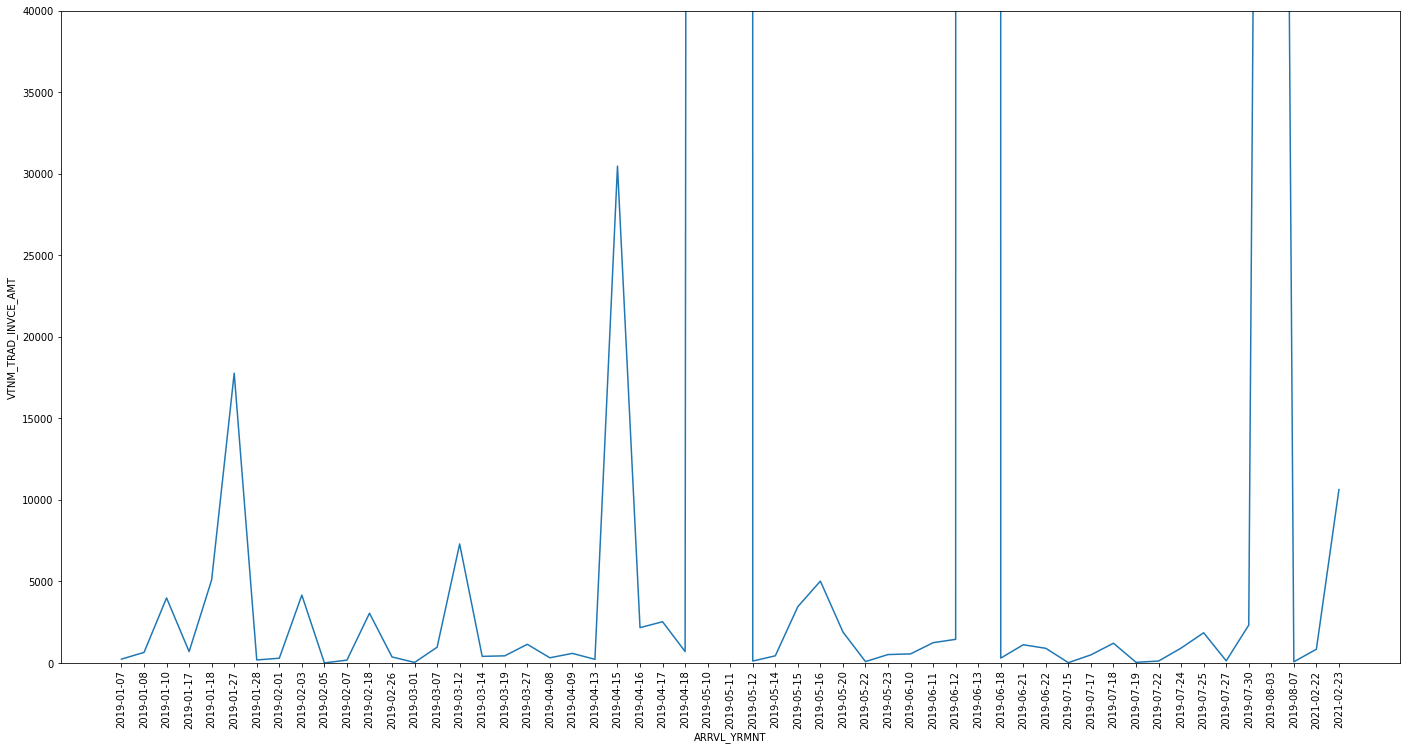

In [68]:
amt = "VTNM_TRAD_INVCE_AMT"
arrvl = "ARRVL_YRMNT"
f, ax = plt.subplots(figsize=(24,12))
fig = sns.lineplot(x=arrvl, y=amt, data=viet_hscd1_lineplot)
fig.axis(ymin=0, ymax = 40000);
plt.xticks(rotation=90);

미친 값들이 존재한다.
미친 송장비용을 보여주는 날짜를 그래프를 통해 확인해본 결과, 2019년 5월 10일, 2019년 5월 11일, 2019년 6월 13일, 2019년 8월 3일 정도인 것 같다.
이 날짜의 데이터값을 확인해보았다.

해당 날짜에 대한 데이터행을 삭제하고 lineplot을 다시 그려보았다.